In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import random

from analysis import *
import evaluation_data_definitions as edd

import nltk

In [300]:
surge_annotations = data.surge_evaluation.annotation_dataframe()
surge_annotations_comparative = data.surge_evaluation.comparative_annotation_dataframe()

surge_annotations

0  \
bot            category        label           item                               
rerank_blender likert dialogue engaging        (1055,38)_rerank_blender       4   
                               informative     (1055,38)_rerank_blender       3   
                               relevant        (1055,38)_rerank_blender       4   
                               quality         (1055,38)_rerank_blender       3   
                               grammatical     (1055,38)_rerank_blender       4   
...                                                                          ..   
               behavior        correct fact    ((441,26)_rerank_blender, 14)  1   
                               incorrect fact  ((441,26)_rerank_blender, 14)  0   
                               uninterpretable ((441,26)_rerank_blender, 14)  0   
                               preference info ((441,26)_rerank_blender, 14)  1   
                               life info       ((441,26)_rerank_blender, 14)  0   

                                                                                1  \
bot            category        label           item                                 
rerank_blender likert dialogue engaging        (1055,38)_rerank_blender       1.0   
                               informative     (1055,38)_rerank_blender       2.0   
                               relevant        (1055,38)_rerank_blender       2.0   
                               quality         (1055,38)_rerank_blender       2.0   
                               grammatical     (1055,38)_rerank_blender       2.0   
...                                                                           ...   
               behavior        correct fact    ((441,26)_rerank_blender, 14)  NaN   
                               incorrect fact  ((441,26)_rerank_blender, 14)  NaN   
                               uninterpretable ((441,26)_rerank_blender, 14)  NaN   
                               preference info ((441,26)_rerank_blender, 14)  NaN   
                               life info       ((441,26)_rerank_blender, 14)  NaN   

                                                                               2  
bot            category        label           item                               
rerank_blender likert dialogue engaging        (1055,38)_rerank_blender      NaN  
                               informative     (1055,38)_rerank_blender      NaN  
                               relevant        (1055,38)_rerank_blender      NaN  
                               quality         (1055,38)_rerank_blender      NaN  
                               grammatical     (1055,38)_rerank_blender      NaN  
...                                                                           ..  
               behavior        correct fact    ((441,26)_rerank_blender, 14) NaN  
                               incorrect fact  ((441,26)_rerank_blender, 14) NaN  
                               uninterpretable ((441,26)_rerank_blender, 14) NaN  
                               preference info ((441,26)_rerank_blender, 14) NaN  
                               life info       ((441,26)_rerank_blender, 14) NaN  

[151824 rows x 3 columns]

In [301]:
def to_file(f):
    def fn_to_file(*args, load=None, reload=None, **kwargs):
        if load:
            return pd.read_pickle(load)
        result = f(*args, **kwargs)
        if reload:
            result.to_pickle(reload)
            return pd.read_pickle(reload)
        return result
    return fn_to_file

In [302]:
def prettify(df, float_prec=None, col_types=None, sort_by=None, to_csv=None, index=True, header=True):
    if col_types:
        for col, type in col_types.items():
            df[col] = df[col].astype(type)
    if sort_by:
        df.sort_values(sort_by, ascending=False, inplace=True)
    if float_prec:
        df = df.round(float_prec)
    if to_csv:
        df.to_csv(to_csv, float_format=f"%.{float_prec}f", header=header, index=index)
    return df

In [303]:
@to_file
def across_evaluations(annotations, evaluation_fn):
    """
    :param annotations: iterable of annotations df to apply evaluation_fn to
    :param evaluation_fn: function (input is annotations df, output is results df)
    :return: results dataframe where first index level codes which evaluation (integer id)
    """
    results = [evaluation_fn(annotation) for annotation in annotations]
    all_results = pd.concat(results, keys=range(len(results)))
    all_results.index.set_names('round', level=0, inplace=True)
    return all_results

# 3 Behavior Evaluation Procedure

### Behavior Examples

In [304]:
def get_example(
        evaluation,
        category,
        label,
        mark,
        bot=None,
        context=0,
        seed=123,
        annotations: pd.DataFrame = None
):
    if annotations is None:
        annotations = evaluation.annotation_dataframe()
    labels = annotations.xs((category, label), level=(1, 2)).reset_index()
    options = labels[labels[0] == mark]
    if bot:
        options = options[options[sym.bot] == bot]
    try:
        example = options.sample(1, random_state=seed)
    except ValueError:
        return f'No samples for {category} {label} {mark} {bot}\n'
    eid = example[sym.item].item()
    if isinstance(eid, tuple):
        did, tid = eid
        turns = evaluation.dialogues[did].turns[max(0, tid-context):tid+1]
        botstring = '' if not bot else f'{bot}~~~\n'
        contextstring = ''.join((
            (
                f'User:  {turn.user_turn}\n'
                f'Sys:   {turn.bot_turn}\n'
            )
            for turn in turns[:-1]
        ))
        turn = turns[-1]
        turnstring = (
            f'User:  {turn.user_turn}\n'
            f'Sys:   {turn.bot_turn}\n'
            f'Label: {label} = {mark}\n'
        )
        return botstring + contextstring + turnstring
    else:
        dialogue = evaluation.dialogues[eid]
        turns = [
            turn
            for turn_pair in dialogue.turns
            for turn in (turn_pair.user_turn, turn_pair.bot_turn)
        ]
        return '\n'.join([f'{dialogue.bot}~~~', *turns, f'Label: {label} = {mark}\n'])


In [305]:
seeds = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
for s, b in zip(seeds, behavior):
    print(get_example(
        data.surge_evaluation,
        category.behavior, b, context=0, mark=1,
        seed=s,
        annotations=surge_annotations
    ))

User:  Yeah, I guess a lot of them are pretty sad people too just looking for someway to feel something 
Sys:   Yeah, that's what I think too. I think it's because they don't have anything going on in their lives.
Label: antisocial = 1

User:  We met through a dating app. We keep in contact a lot, and it's good conversation.
Sys:   Is that where you met this new person? How long have you been together? It's nice to see happy endings!
Label: commonsense contradiction = 1

User:  I am a student
Sys:   Wow, I don't think I've ever heard of that. What kind of job is it?
Label: partner contradiction = 1

User:  I see, do you have a family living there? Or just for vacation?
Sys:   Just for vacation. I've never been to florida, but I've always wanted to go.
Label: self contradiction = 1

User:  Very good!
Sys:   Do you watch hockey? I used to love it. I am old now. Lol!
Label: ignore = 1

User:  Wait, what songs are in that album?
Sys:   There are a lot of great songs on that album. I especi

### Behavior Annotation Pilot Agreements

In [306]:
@to_file
def agreement_dataframe(annotations, ci=True):
    doubly_annotated = annotations.iloc[:,:2].dropna().astype(int)
    label_groups = doubly_annotated.groupby(level=[sym.category, sym.label])
    kappas = label_groups.apply(fleiss_kappa, ci=ci)
    alphas = label_groups.apply(krippendorfs_alpha, ci=ci)
    agreements = pd.concat((alphas, kappas), axis=1)
    return agreements

In [307]:
@to_file
def agreement_summaries(evaluations):
    summaries = []
    for evaluation in evaluations:
        annotations = evaluation.annotation_dataframe()
        agreement = agreement_dataframe(annotations, ci=False)
        macros = agreement.dropna().mean()
        summaries.append(macros)
    sum_df = pd.concat(summaries, axis=1).transpose()
    sum_df.set_axis(
        [stat.kripp_alpha, 'x', stat.fleiss_kappa, stat.n],
        inplace=True, axis=1
    )
    sum_df.drop('x', axis=1, inplace=True)
    return sum_df

In [308]:
# todo - include ALL pilot annotations in agreement calculation (not just double annotation)
agreement_summaries(data.annotation_pilots)

,Krippendorff's alpha,Fleiss' kappa,n
0,0.112585,0.105706,65.000000
1,0.377984,0.356535,15.000000
2,0.182412,0.154556,15.500000
3,0.261712,0.172157,120.486486
4,0.351674,0.294750,41.222222


### Behavior Annotation Pilot Screening

In [309]:
@to_file
def screening_rates_by_label(evaluation: edd.OnboardingEvaluation):
    perfs = {}
    workers_passed = {}
    workers_attempted = {}
    for did, dialogue in evaluation.dialogues.items():
        for attempt in dialogue.attempts:
            work_unit = evaluation.work_units[attempt.work_unit_id]
            round = int(did.split('_')[-1])
            task = work_unit.task
            labels = work_unit.labels
            num_mistakes = len(attempt.mistakes)
            worker = work_unit.worker_id
            accuracy = attempt.performance
            perfs.setdefault(task, []).append((num_mistakes, accuracy))
            workers_attempted.setdefault(task, set()).add(worker)
            if attempt.passed:
                workers_passed.setdefault(task, set()).add(worker)
    screening = {}
    for task, ls in perfs.items():
        mistakes, accuracies = zip(*ls)
        avg_m = sum(mistakes) / len(mistakes)
        avg_a = (
            sum(accuracies) / len(accuracies)
            if all((a is not None for a in accuracies)) else None
        )
        n = len(mistakes)
        attempted = len(workers_attempted.get(task, ()))
        passed = len(workers_passed.get(task, ()))
        screening[task] = {
            'attempted': attempted, 'passed': passed,
            'mistakes': avg_m, 'accuracy': avg_a, 'n': n
        }
    return pd.DataFrame(screening.values(), screening)

In [310]:
across_evaluations(
    data.annotation_pilots_onboarding[2:4],
    screening_rates_by_label,
    load='results/annotation_pilot_screening'
)

attempted  passed  mistakes  accuracy   n
round                                                                
0     transitions                   4       4  6.000000  0.660621  11
      knowledge                     4       4  2.666667  0.775214  12
      consistency                   4       4  5.500000  0.647395  10
      interpretability              4       4  0.250000  0.979167   4
      commonsense                   4       4  2.000000  0.856456   8
      sociality                     4       4  0.400000  0.960000   5
1     transitions                   5       5  4.000000  0.750000   5
      knowledge                     7       6  2.833333  0.772009  12
      consistency                   4       4  5.090909  0.672116  11
      interpretability              5       5  1.000000  0.913420   7
      empathy                      10       8  4.700000  0.686667  20
      personal_information          8       7  3.500000  0.766667  16
      commonsense                   7       7  3.100000  0.777473  10
      sociality                     4       4  0.750000  0.925000   4

# 4 Model Selection

### Bot Pilot Summary Statistics

In [311]:
@to_file
def interactor_summary_stats(evaluation: edd.Evaluation):
    num_dialogues = len(evaluation.dialogues)
    mean_turns = (
        sum((
            2*len(d.turns)
            for d in evaluation.dialogues.values()
        ))
        / num_dialogues
    )
    user_turn_len = (
        sum((
            len(nltk.word_tokenize(t.user_turn))
            for d in evaluation.dialogues.values()
            for t in d.turns
        ))
        / sum((
            len(d.turns)
            for d in evaluation.dialogues.values()
        ))
    )
    num_interactors = len({
        unit.worker_id
        for unit in evaluation.work_units.values()
    })
    summary = {
        'dialogues': num_dialogues,
        'mean turns': mean_turns,
        'user turn length': user_turn_len,
        'interactors': num_interactors,
    }
    return pd.DataFrame(summary.values(), summary)

In [312]:
across_evaluations(
    data.bot_pilots, interactor_summary_stats,
    load='results/bot_pilot_summary'
)

0
round                            
0     dialogues         66.000000
      mean turns        30.909091
      user turn length   9.638235
      interactors       44.000000

### Bot Pilots Likert Quality

In [313]:
@to_file
def evaluate_interactive_likert(annotations):
    likert_annotations = annotations.xs(category.likert_dialogue, level=sym.category)
    label_groups = likert_annotations.groupby(level=[sym.bot, sym.label])
    means = label_groups.apply(mean_and_ci)
    return means

qdf = evaluate_interactive_likert(
    data.bot_pilots[0].annotation_dataframe(),
    load='results/bot_pilot_interactive_likert'
).xs(scale.quality, level=sym.label)
qdf = prettify(qdf, float_prec=3, col_types={"n": "int"}, sort_by="mean", to_csv="results/paper/bot_pilot_interactive_likert_quality")
qdf

,mean,CI low,CI high,n
bot,,,,
blender2_3B,3.400,1.734,5.066,5
emora,3.400,2.631,4.169,10
rerank_blender,3.100,2.120,4.080,10
bart_fid_rag_bcb,2.700,1.805,3.595,10
rerank_blender2,2.100,1.244,2.956,10
dukenet,1.889,1.176,2.602,9
cem,1.083,0.900,1.267,12


### Bot Pilot Comparative Quality

In [314]:
def get_singly_annotated(df: pd.DataFrame, seed=None):
    if len(df.columns) == 1:
        return df.astype(int)
    previous_state = random.getstate()
    random.seed(seed)
    df = df.iloc[:,:2]
    mask = df[1].isna()
    singly_annotated = df.iloc[:,0][mask]
    doubly_annotated = df[~mask]
    selection = [random.randint(0, 1) for _ in range(len(doubly_annotated))]
    indices = list(range(len(doubly_annotated)))
    select_annotated = doubly_annotated.values[indices, selection]
    select_annotated = pd.DataFrame(select_annotated, index=doubly_annotated.index)
    annotations = pd.concat((singly_annotated, select_annotated))
    random.setstate(previous_state)
    return annotations.astype(int)

In [315]:
@to_file
def evaluate_comparisons(annotations):
    single_annotated = get_singly_annotated(annotations)
    prop_dfs = []
    for cmp, cmp_label in {-1: 'lose', 0: 'tie', 1: 'win'}.items():
        annotated = single_annotated == cmp
        annotated = annotated.astype(int)
        groups = annotated.groupby(level=[sym.bot, sym.bot_cmp, sym.label])
        props = groups.apply(prop_and_ci)
        props.rename(columns={stat.proportion: cmp_label}, inplace=True)
        prop_dfs.append(props)
    result = pd.concat(prop_dfs, axis=1)
    prop_dfs = []
    for cmp, cmp_label in {-1: 'lose', 0: 'tie', 1: 'win'}.items():
        annotated = single_annotated == cmp
        annotated = annotated.astype(int)
        groups = annotated.groupby(level=[sym.bot, sym.label])
        props = groups.apply(prop_and_ci)
        props.rename(columns={stat.proportion: cmp_label}, inplace=True)
        prop_dfs.append(props)
    result_vs_all = pd.concat(prop_dfs, axis=1)
    others_idx = {sym.bot_cmp: 'others'}
    result_vs_all = result_vs_all.assign(**others_idx)
    levels = [sym.bot, sym.bot_cmp, sym.label]
    result_vs_all = result_vs_all.set_index(sym.bot_cmp, append=True)
    result_vs_all = result_vs_all.reset_index().set_index(levels)
    result = pd.concat((result_vs_all, result))
    return result

cmp_annot = data.bot_pilots[0].comparative_annotation_dataframe()

cmp = evaluate_comparisons(
    cmp_annot,
    load='results/bot_pilot_interactive_comparative'
)
cmp

lose    CI low   CI high     n  tie  \
bot              bot comp label                                              
bart_fid_rag_bcb others   consistent    0.6  0.312674  0.831820  10.0  0.0   
                          emotional     0.4  0.168180  0.687326  10.0  0.0   
                          engaging      0.5  0.236593  0.763407  10.0  0.0   
                          grammatical   0.3  0.107791  0.603222  10.0  0.1   
                          informative   0.3  0.107791  0.603222  10.0  0.0   
...                                     ...       ...       ...   ...  ...   
rerank_blender2  emora    grammatical   0.0  0.000000  0.657620   2.0  0.5   
                          informative   0.0  0.000000  0.657620   2.0  0.5   
                          proactive     1.0  0.342380  1.000000   2.0  0.0   
                          quality       1.0  0.342380  1.000000   2.0  0.0   
                          relevant      0.5  0.094531  0.905469   2.0  0.5   

                                         CI low   CI high     n  win  \
bot              bot comp label                                        
bart_fid_rag_bcb others   consistent   0.000000  0.277533  10.0  0.4   
                          emotional    0.000000  0.277533  10.0  0.6   
                          engaging     0.000000  0.277533  10.0  0.5   
                          grammatical  0.017876  0.404150  10.0  0.6   
                          informative  0.000000  0.277533  10.0  0.7   
...                                         ...       ...   ...  ...   
rerank_blender2  emora    grammatical  0.094531  0.905469   2.0  0.5   
                          informative  0.094531  0.905469   2.0  0.5   
                          proactive    0.000000  0.657620   2.0  0.0   
                          quality      0.000000  0.657620   2.0  0.0   
                          relevant     0.094531  0.905469   2.0  0.0   

                                         CI low   CI high     n  
bot              bot comp label                                  
bart_fid_rag_bcb others   consistent   0.168180  0.687326  10.0  
                          emotional    0.312674  0.831820  10.0  
                          engaging     0.236593  0.763407  10.0  
                          grammatical  0.312674  0.831820  10.0  
                          informative  0.396778  0.892209  10.0  
...                                         ...       ...   ...  
rerank_blender2  emora    grammatical  0.094531  0.905469   2.0  
                          informative  0.094531  0.905469   2.0  
                          proactive    0.000000  0.657620   2.0  
                          quality      0.000000  0.657620   2.0  
                          relevant     0.000000  0.657620   2.0  

[216 rows x 12 columns]

### Bot Pilot Conversation Examples

In [316]:
seeds = [1, 1, 1, 1, 1, 1, 1]
for s, b in zip(seeds, bot):
    example = get_example(
        data.bot_pilots[0],
        category.likert_dialogue, label=scale.quality, bot=b, context=0, mark=1,
        seed=s
    )
    print(example)

blender2_3B~~~
Hi!
Hello, how are you? 
I'm good, how are you?
I'm doing well, thank you for asking. How's the weather in your neck of the woods?
It's not as cold as it was last week, which is nice. What's it like where you are?
I'm in the midwest, so it's pretty cold right now. I'm hoping it warms up soon.
Me too
Do you have any plans for the weekend? Or are you just going to stay home and watch tv?
I plan on visiting my parents and just chilling at home.
That sounds relaxing. I wish I could do that, but I have to work this weekend.
Dang. What do you do for work?
I work as a cashier at a grocery store. It pays the bills, so I can't complain.
Ah, sounds like chore tho
It's not too bad. I get to listen to music while I work, which is nice.
Oh that does sound nice. I listen to music when I work on homework.
What kind of music do you listen to? I'm a big fan of classical music myself.
I listen to pop punk pretty frequently, but anime music has made its way into my rotation.
That's cool. I

# 5 Conversation Collection

In [317]:
"""
Time results to collect conversations
"""

'\nTime results to collect conversations\n'

### Conversation Data Summary Statistics

In [318]:
df = interactor_summary_stats(
    data.dialogue_collection,
    load='results/conversation_summary_stats'
)
df = prettify(df, float_prec=3, to_csv="results/paper/conversation_data_summary", index=False, header=False)
df

,0
dialogues,588.000
mean turns,30.667
user turn length,11.418
interactors,46.000


# 6 Evaluation

In [319]:
"""
Timing results for training and collection (per task)
"""

'\nTiming results for training and collection (per task)\n'

### Worker Group Completed Work

In [320]:
data.surge_evaluation.annotation_counts()

dialogues annotated  \
likert dialogue engaging                                 400.0   
                informative                              400.0   
                relevant                                 400.0   
                quality                                  400.0   
                grammatical                              400.0   
                emotional                                400.0   
                consistent                               400.0   
                proactive                                400.0   
comparative     consistent                               202.0   
                grammatical                              202.0   
                engaging                                 202.0   
                quality                                  202.0   
                proactive                                202.0   
                informative                              202.0   
                emotional                                202.0   
                relevant                                 202.0   
likert turn     consistent                               400.0   
                proactive                                400.0   
                informative                              400.0   
                relevant                                 400.0   
                grammatical                              400.0   
                quality                                  400.0   
                engaging                                 400.0   
                emotional                                400.0   
behavior        redundant                                400.0   
                self contradiction                       400.0   
                partner contradiction                    400.0   
                empathetic                               400.0   
                lack of empathy                          400.0   
                commonsense contradiction                400.0   
                antisocial                               400.0   
                follow up                                400.0   
                topic switch                             400.0   
                ignore                                   400.0   
                irrelevant                               400.0   
                correct fact                             400.0   
                incorrect fact                           400.0   
                uninterpretable                          400.0   
                preference info                          400.0   
                life info                                400.0   

                                           double annotated  
likert dialogue engaging                              108.0  
                informative                           108.0  
                relevant                              108.0  
                quality                               108.0  
                grammatical                           108.0  
                emotional                             108.0  
                consistent                            108.0  
                proactive                             108.0  
comparative     consistent                             54.0  
                grammatical                            54.0  
                engaging                               54.0  
                quality                                54.0  
                proactive                              54.0  
                informative                            54.0  
                emotional                              54.0  
                relevant                               54.0  
likert turn     consistent                            108.0  
                proactive                             108.0  
                informative                           108.0  
                relevant                              108.0  
                grammatical       

In [321]:
data.student_evaluation.annotation_counts()

dialogues annotated  \
likert dialogue relevant                                  15.0   
                grammatical                               15.0   
                consistent                                15.0   
                informative                               15.0   
                quality                                   15.0   
                engaging                                  15.0   
                emotional                                 15.0   
                proactive                                 15.0   
comparative     consistent                                12.0   
                emotional                                 12.0   
                engaging                                  12.0   
                informative                               12.0   
                grammatical                               12.0   
                proactive                                 12.0   
                quality                                   12.0   
                relevant                                  12.0   
likert turn     grammatical                               24.0   
                relevant                                  24.0   
                informative                               24.0   
                emotional                                 10.0   
                engaging                                  10.0   
                consistent                                14.0   
                quality                                    4.0   
behavior        empathetic                                10.0   
                lack of empathy                           10.0   
                correct fact                              12.0   
                incorrect fact                            12.0   
                uninterpretable                           10.0   
                preference info                            5.0   
                life info                                  5.0   
                commonsense contradiction                 12.0   
                antisocial                                15.0   
                redundant                                  4.0   
                self contradiction                         4.0   
                partner contradiction                      4.0   

                                           double annotated  
likert dialogue relevant                               10.0  
                grammatical                            10.0  
                consistent                             10.0  
                informative                            10.0  
                quality                                10.0  
                engaging                               10.0  
                emotional                              10.0  
                proactive                              10.0  
comparative     consistent                              6.0  
                emotional                               6.0  
                engaging                                6.0  
                informative                             6.0  
                grammatical                             6.0  
                proactive                               6.0  
                quality                                 6.0  
                relevant                                6.0  
likert turn     grammatical                            24.0  
                relevant                               24.0  
                informative                            24.0  
                emotional                               0.0  
                engaging                                0.0  
                consistent                              0.0  
                quality                                 0.0  
behavior        empathetic                              0.0  
                lack of empathy                         0.0  
                correct fact                          

In [322]:
data.mturk_evaluation.annotation_counts()

dialogues annotated  \
likert dialogue emotional                                  5.0   
                proactive                                  5.0   
                quality                                    5.0   
                engaging                                   5.0   
                relevant                                   5.0   
                informative                                5.0   
                consistent                                 5.0   
                grammatical                                5.0   
comparative     grammatical                                4.0   
                quality                                    4.0   
                emotional                                  4.0   
                proactive                                  4.0   
                relevant                                   4.0   
                consistent                                 4.0   
                engaging                                   4.0   
                informative                                4.0   
likert turn     grammatical                                5.0   
                relevant                                   5.0   
                informative                                5.0   
                emotional                                  5.0   
                engaging                                   5.0   
                consistent                                 5.0   
                proactive                                  5.0   
                quality                                    5.0   
behavior        antisocial                                 5.0   
                preference info                            5.0   
                life info                                  5.0   
                correct fact                               5.0   
                incorrect fact                             5.0   
                commonsense contradiction                  5.0   
                redundant                                  5.0   
                self contradiction                         5.0   
                partner contradiction                      5.0   
                uninterpretable                            5.0   
                empathetic                                 2.0   
                lack of empathy                            2.0   

                                           double annotated  
likert dialogue emotional                               5.0  
                proactive                               5.0  
                quality                                 5.0  
                engaging                                5.0  
                relevant                                5.0  
                informative                             5.0  
                consistent                              5.0  
                grammatical                             5.0  
comparative     grammatical                             4.0  
                quality                                 4.0  
                emotional                               4.0  
                proactive                               4.0  
                relevant                                4.0  
                consistent                              4.0  
                engaging                                4.0  
                informative                             4.0  
likert turn     grammatical                             5.0  
                relevant                                5.0  
                informative                             5.0  
                emotional                               5.0  
                engaging                                5.0  
                consistent                              5.0  
                proactive                               5.0  
                quality                                 5.0  
behavior        antisocial                        

### Worker Group Screening

In [323]:
screening = across_evaluations(
    [data.annotation_pilots_onboarding[-2], data.student_onboarding, data.mturk_onboarding, data.annotation_pilots_onboarding[-1], data.surge_onboarding],
    screening_rates_by_label,
    load='results/evaluation_screening'
)


### Agreements

In [324]:
agreements = agreement_dataframe(
    surge_annotations, load='results/surge_agreements'
)
agreements = prettify(agreements, float_prec=3, sort_by=["category", "Krippendorff's alpha"], col_types={"n": int}, to_csv='results/paper/surge_agreements', index=False)
agreements

Krippendorff's alpha  CI low  \
category        label                                                     
likert turn     grammatical                               0.419   0.373   
                quality                                   0.312   0.262   
                engaging                                  0.295   0.247   
                proactive                                 0.279   0.233   
                informative                               0.278   0.230   
                relevant                                  0.239   0.191   
                consistent                                0.201   0.151   
                emotional                                 0.166   0.113   
likert dialogue informative                               0.409   0.270   
                consistent                                0.360   0.200   
                relevant                                  0.298   0.146   
                quality                                   0.286   0.119   
                engaging                                  0.259   0.051   
                emotional                                 0.256   0.085   
                proactive                                 0.243   0.072   
                grammatical                               0.132  -0.040   
comparative     consistent                                0.484   0.293   
                quality                                   0.447   0.266   
                relevant                                  0.418   0.232   
                proactive                                 0.226   0.053   
                grammatical                               0.215   0.047   
                informative                               0.209   0.031   
                emotional                                 0.202   0.026   
                engaging                                  0.115  -0.052   
behavior        topic switch                              0.755   0.712   
                incorrect fact                            0.652   0.573   
                life info                                 0.631   0.590   
                correct fact                              0.618   0.568   
                ignore                                    0.571   0.505   
                antisocial                                0.553   0.220   
                redundant                                 0.551   0.478   
                empathetic                                0.514   0.473   
                follow up                                 0.492   0.450   
                preference info                           0.491   0.448   
                irrelevant                                0.456   0.399   
                commonsense contradiction                 0.442   0.388   
                partner contradiction                     0.436   0.363   
                lack of empathy                           0.435   0.375   
                self contradiction                        0.407   0.327   
                uninterpretable                           0.137   0.028   

                                           CI high     n  Fleiss' kappa  \
category        label                                                     
likert turn     grammatical                  0.468  1634          0.296   
                quality                      0.356  1634          0.092   
                engaging                     0.345  1634          0.123   
                proactive                    0.323  1634          0.098   
                informative                  0.323  1634          0.092   
                relevant                     0.286  1634          0.100   
                consistent                   0.251  1634          0.083   
                emotional                    0.213  1634          0.021   
likert dialogue informative                  0.550   108          0.031   
                consistent                   0.509   108          0

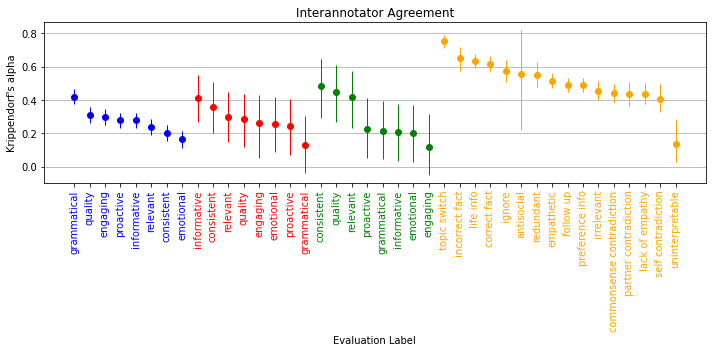

In [325]:
# Build the plot
plt.rcParams["figure.figsize"] = (10,5)

fig, ax = plt.subplots()

def plot_by_category(ax, df, category, color, xaxis_start):
    extracted = df[df["category"] == category]
    lower_bound = extracted["Krippendorff's alpha"] - extracted["CI low"]
    upper_bound = extracted["CI high"] - extracted["Krippendorff's alpha"]
    xaxis_end = xaxis_start + len(extracted)
    ax.errorbar(np.arange(xaxis_start, xaxis_end),
                extracted["Krippendorff's alpha"],
                yerr=[lower_bound, upper_bound],
                fmt='o',
                elinewidth=1,
                color=color)
    return xaxis_end

likert_turn_color = "blue"
likert_dialogue_color = "red"
comparative_color = "green"
behavior_color = "orange"

krip_agreements = agreements.iloc[: , :-4]
krip_agreements = krip_agreements.reset_index()
likert_dialogue_start = plot_by_category(ax, krip_agreements, "likert turn", likert_turn_color, 0)
comparative_start = plot_by_category(ax, krip_agreements, "likert dialogue", likert_dialogue_color, likert_dialogue_start)
behavior_start = plot_by_category(ax, krip_agreements, "comparative", comparative_color, comparative_start)
misc_start = plot_by_category(ax, krip_agreements, "behavior", behavior_color, behavior_start)

category_range = {likert_dialogue_start: likert_turn_color, comparative_start: likert_dialogue_color, behavior_start: comparative_color, misc_start: behavior_color}
xaxis_colors = {}
prev_idx = 0
for idx, color in category_range.items():
    for i in range(prev_idx, idx):
        xaxis_colors[i] = color
    prev_idx = idx

ax.set_ylabel("Krippendorf's alpha")
xpos = np.arange(len(krip_agreements))
ax.set_xlabel("Evaluation Label")
ax.set_xticks(xpos)
ax.set_xticklabels(krip_agreements["label"], rotation=90)
for tickloc, ticklabel in zip(plt.gca().get_xticks(), plt.gca().get_xticklabels()):
    ticklabel.set_color(xaxis_colors[tickloc])
ax.set_title('Interannotator Agreement')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [326]:
# all_agreements = across_evaluations(
#     [
#         e.annotation_dataframe() for e in
#         (data.student_evaluation, data.mturk_evaluation, data.surge_evaluation)
#     ],
#     agreement_dataframe,
#     reload='results/evaluation_agreements'
# )
# all_agreements = prettify(all_agreements, float_prec=3, sort_by=["round", "category", "Krippendorff's alpha"], col_types={"n": int}, to_csv='results/paper/all_agreements', index=False)
# all_agreements

# 7 Comprehensive Analysis

### Likert Dialogue

In [327]:
bots = ['Blender2', 'Emora', 'BartFidRAG', 'RerankBlender']
# https://blog.finxter.com/how-to-plot-matplotlibs-color-palette-and-choose-your-plot-color/
graphing_bot_colors = {
    'blender2_3B': 'purple',
    'bart_fid_rag_bcb': 'royalblue',
    'emora': 'turquoise',
    'rerank_blender': 'green'
}
bot_transformer = {
    'blender2_3B': 'Blender2',
    'emora': 'Emora',
    'rerank_blender': 'Blender-Decode',
    'bart_fid_rag_bcb': 'BART-FiDRAG'
}
dimensions_transformer = {
    'consistent': 'CO',
    'emotional': 'EU',
    'engaging': 'EN',
    'grammatical': 'GR',
    'informative': 'IN',
    'proactive': 'PR',
    'quality': 'OQ',
    'relevant': 'RE'
}

In [328]:
def grouped_barplot(df0, title, ylabel, xlabel, ylim, value_col='mean', rot=45, fig_size=(10,5)):
    df = df0.reset_index()
    plt.rcParams["figure.figsize"] = fig_size

    df['lower'] = df[value_col] - df["CI low"]
    cilow = df.pivot(index='label', columns='bot', values='lower')
    df['upper'] = df["CI high"] - df[value_col]
    cihigh = df.pivot(index='label', columns='bot', values='upper')

    err = []
    for col in cilow:
        err.append([cilow[col].values, cihigh[col].values])

    df0 = df.pivot(index='label', columns='bot', values=value_col)
    ax = df0.plot(
        kind='bar',
        ylim=ylim,
        title=title,
        rot=rot,
        yerr=err,
        color=[graphing_bot_colors[bot] for bot in df0.columns]
    )
    ax.legend(
        [bot_transformer[bot] for bot in df0.columns],
        ncol=2
    )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticklabels([dimensions_transformer[d] if d in dimensions_transformer else behaviors_transformer[d] for d in df0.index])

In [329]:
def evaluate_likert_ratings(annotations, category, load=None, reload=None):
    if load:
        return pd.read_csv(load)
    single_annotated = get_singly_annotated(annotations)
    likert_annotations = single_annotated.xs(category, level=sym.category)
    label_groups = likert_annotations.groupby(level=[sym.bot, sym.label])
    means = label_groups.apply(mean_and_ci)
    if reload:
        means.to_csv(reload)
    return means

In [330]:
surge_likert_dialogue_ratings = evaluate_likert_ratings(
    surge_annotations, category.likert_dialogue,
    load='results/surge_likert_dialogue_ratings'
)
sldr = prettify(surge_likert_dialogue_ratings, float_prec=3, col_types={"n": int}, sort_by=["bot", "mean"], to_csv="results/paper/surge_likert_dialogue_ratings", index=False)
sldr

,bot,label,mean,CI low,CI high,n
28,rerank_blender,informative,3.95,3.769,4.131,100
26,rerank_blender,engaging,3.93,3.734,4.126,100
25,rerank_blender,emotional,3.85,3.648,4.052,100
29,rerank_blender,proactive,3.81,3.601,4.019,100
24,rerank_blender,consistent,3.64,3.397,3.883,100
27,rerank_blender,grammatical,3.56,3.345,3.775,100
31,rerank_blender,relevant,3.56,3.346,3.774,100
30,rerank_blender,quality,3.23,3.037,3.423,100
21,emora,proactive,4.04,3.853,4.227,100
19,emora,grammatical,3.94,3.783,4.097,100


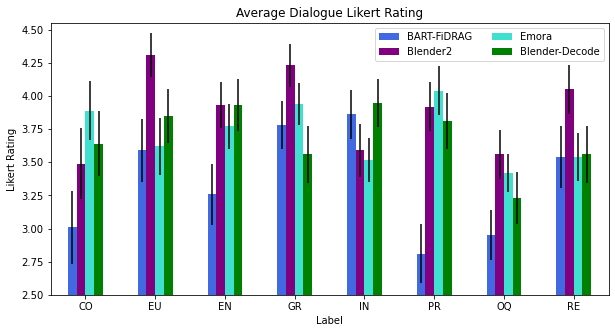

In [331]:
grouped_barplot(sldr, title="Average Dialogue Likert Rating", ylabel="Likert Rating", xlabel='Label', ylim=(2.5,4.55), rot=0, fig_size=(10,5))

### Likert Turn

In [332]:
surge_likert_turn_ratings = evaluate_likert_ratings(
    surge_annotations, category.likert_turn,
    load='results/surge_likert_turn_ratings'
)
sltr = prettify(surge_likert_turn_ratings, float_prec=3, col_types={"n": int}, sort_by=["bot", "mean"], to_csv="results/paper/surge_likert_turn_ratings", index=False)
sltr

,bot,label,mean,CI low,CI high,n
25,rerank_blender,emotional,4.197,4.144,4.250,1500
24,rerank_blender,consistent,4.064,4.003,4.125,1500
27,rerank_blender,grammatical,4.007,3.954,4.060,1500
26,rerank_blender,engaging,3.827,3.765,3.888,1500
28,rerank_blender,informative,3.731,3.677,3.786,1500
31,rerank_blender,relevant,3.727,3.662,3.793,1500
29,rerank_blender,proactive,3.661,3.599,3.722,1500
30,rerank_blender,quality,3.307,3.246,3.367,1500
19,emora,grammatical,4.546,4.512,4.580,1522
16,emora,consistent,4.143,4.084,4.202,1522


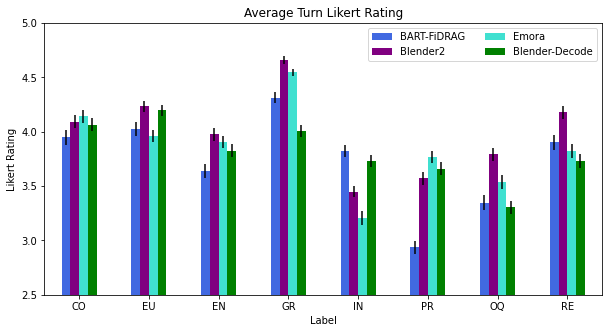

In [333]:
grouped_barplot(sltr, title="Average Turn Likert Rating", ylabel="Likert Rating", xlabel='Label', ylim=(2.5,5.0), rot=0)

### Comparative

In [334]:
comparison_df = evaluate_comparisons(
    surge_annotations_comparative,
    load='results/surge_comparisons'
)
comparison_df

lose    CI low   CI high      n  \
bot              bot comp label                                              
bart_fid_rag_bcb others   consistent   0.613861  0.516402  0.702977  101.0   
                          emotional    0.584158  0.486681  0.675468  101.0   
                          engaging     0.613861  0.516402  0.702977  101.0   
                          grammatical  0.415842  0.324532  0.513319  101.0   
                          informative  0.435644  0.343060  0.532944  101.0   
...                                         ...       ...       ...    ...   
rerank_blender   emora    grammatical  0.333333  0.197502  0.503921   33.0   
                          informative  0.272727  0.150674  0.442176   33.0   
                          proactive    0.424242  0.272356  0.591927   33.0   
                          quality      0.454545  0.298429  0.620141   33.0   
                          relevant     0.484848  0.325040  0.647816   33.0   

                                            tie        CI low   CI high  \
bot              bot comp label                                           
bart_fid_rag_bcb others   consistent   0.000000  3.469447e-18  0.036641   
                          emotional    0.059406  2.750813e-02  0.123591   
                          engaging     0.009901  1.749911e-03  0.053967   
                          grammatical  0.188119  1.238713e-01  0.275221   
                          informative  0.000000  3.469447e-18  0.036641   
...                                         ...           ...       ...   
rerank_blender   emora    grammatical  0.151515  6.650457e-02  0.309199   
                          informative  0.000000  0.000000e+00  0.104270   
                          proactive    0.000000  0.000000e+00  0.104270   
                          quality      0.000000  0.000000e+00  0.104270   
                          relevant     0.090909  3.140394e-02  0.235726   

                                           n       win    CI low   CI high  \
bot              bot comp label                                              
bart_fid_rag_bcb others   consistent   101.0  0.386139  0.297023  0.483598   
                          emotional    101.0  0.356436  0.269867  0.453525   
                          engaging     101.0  0.376238  0.287931  0.473614   
                          grammatical  101.0  0.396040  0.306154  0.493543   
                          informative  101.0  0.564356  0.467056  0.656940   
...                                      ...       ...       ...       ...   
rerank_blender   emora    grammatical   33.0  0.515152  0.352184  0.674960   
                          informative   33.0  0.727273  0.557824  0.849326   
                          proactive     33.0  0.575758  0.408073  0.727644   
                          quality       33.0  0.545455  0.379859  0.701571   
                          relevant      33.0  0.424242  0.272356  0.591927   

                                           n  
bot              bot comp label               
bart_fid_rag_bcb others   consistent   101.0  
                          emotional    101.0  
                          engaging     101.0  
                          grammatical  101.0  
                          informative  101.0  
...                                      ...  
rerank_blender   emora    grammatical   33.0  
                          informative   33.0  
                          proactive     33.0  
                          quality       33.0  
                          relevant      33.0  

[128 rows x 12 columns]

In [335]:
# each bot is a dataframe
botvothers = comparison_df[comparison_df.index.get_level_values('bot comp') == 'others'][['win', 'tie', 'lose']]
print(comparison_df.columns)
botvothers['CI low'] = comparison_df.iloc[:, 9]
botvothers['CI high'] = comparison_df.iloc[:, 10]
botvothers.reset_index(level=['bot comp'], inplace=True)
botvothers.drop('bot comp', inplace=True, axis='columns')
toplot = botvothers.reorder_levels(['label', 'bot']).sort_index()
toplot

Index(['lose', 'CI low', 'CI high', 'n', 'tie', 'CI low', 'CI high', 'n',
       'win', 'CI low', 'CI high', 'n'],
      dtype='object')


win       tie      lose    CI low   CI high
label       bot                                                               
consistent  bart_fid_rag_bcb  0.386139  0.000000  0.613861  0.297023  0.483598
            blender2_3B       0.372549  0.009804  0.617647  0.284950  0.469400
            emora             0.663366  0.009901  0.326733  0.566727  0.748034
            rerank_blender    0.530000  0.020000  0.450000  0.432889  0.624892
emotional   bart_fid_rag_bcb  0.356436  0.059406  0.584158  0.269867  0.453525
            blender2_3B       0.500000  0.058824  0.441176  0.404744  0.595256
            emora             0.504950  0.079208  0.415842  0.409065  0.600473
            rerank_blender    0.530000  0.050000  0.420000  0.432889  0.624892
engaging    bart_fid_rag_bcb  0.376238  0.009901  0.613861  0.287931  0.473614
            blender2_3B       0.490196  0.019608  0.490196  0.395314  0.585790
            emora             0.514851  0.000000  0.485149  0.418639  0.609975
            rerank_blender    0.620000  0.030000  0.350000  0.522098  0.709024
grammatical bart_fid_rag_bcb  0.396040  0.188119  0.415842  0.306154  0.493543
            blender2_3B       0.470588  0.166667  0.362745  0.376559  0.566752
            emora             0.396040  0.148515  0.455446  0.306154  0.493543
            rerank_blender    0.420000  0.160000  0.420000  0.327984  0.517935
informative bart_fid_rag_bcb  0.564356  0.000000  0.435644  0.467056  0.656940
            blender2_3B       0.333333  0.000000  0.666667  0.249371  0.429394
            emora             0.445545  0.009901  0.544554  0.352380  0.542700
            rerank_blender    0.680000  0.000000  0.320000  0.583374  0.763309
proactive   bart_fid_rag_bcb  0.257426  0.019802  0.722772  0.182152  0.350475
            blender2_3B       0.490196  0.000000  0.509804  0.395314  0.585790
            emora             0.584158  0.009901  0.405941  0.486681  0.675468
            rerank_blender    0.650000  0.010000  0.340000  0.552544  0.736358
quality     bart_fid_rag_bcb  0.445545  0.009901  0.544554  0.352380  0.542700
            blender2_3B       0.470588  0.009804  0.519608  0.376559  0.566752
            emora             0.544554  0.009901  0.445545  0.447580  0.638264
            rerank_blender    0.570000  0.010000  0.420000  0.472154  0.662667
relevant    bart_fid_rag_bcb  0.405941  0.009901  0.584158  0.315324  0.503450
            blender2_3B       0.480392  0.000000  0.519608  0.385919  0.576289
            emora             0.564356  0.039604  0.396040  0.467056  0.656940
            rerank_blender    0.510000  0.030000  0.460000  0.413480  0.605780

In [336]:
from matplotlib.text import Text

def plot_comparative(df0, title, value_col, fig_size):
    # https://stackoverflow.com/questions/59922701/pandas-how-can-i-group-a-stacked-bar-chart
    plt.rcParams["figure.figsize"] = fig_size

    df0['lower'] = df0[value_col] - df0["CI low"]
    df0['upper'] = df0["CI high"] - df0[value_col]

    errLow = df0[['lower']].reset_index(['bot', 'label']).pivot(index='label', columns='bot', values='lower')
    errHi = df0[['upper']].reset_index(['bot', 'label']).pivot(index='label', columns='bot', values='upper')

    # 4 x 2 x 8 (bots x low, hi x labels)
    err = []
    for col in errLow:
        err.append([errLow[col].values, errHi[col].values])

    df0 = df0.unstack(level=-1)
    fig, ax = plt.subplots()

    groups = []
    for i in df0.columns:
        if i[1] not in groups:
            groups.append(i[1])

    (df0['win']+df0['tie']+df0['lose']).plot(kind='bar', color=[graphing_bot_colors[i] for i in groups], alpha=0.2, rot=0, ax=ax)
    (df0['win']+df0['tie']).plot(kind='bar', color=[graphing_bot_colors[i] for i in groups], alpha=0.4, rot=0, ax=ax)
    df0['win'].plot(kind='bar', color=[graphing_bot_colors[i] for i in groups], rot=0, ax=ax, yerr=err)

    h, l = ax.get_legend_handles_labels()
    markers = {}
    for h, l, (wtl, bot) in zip(h, l, df0.columns):
        markers.setdefault(bot, []).append((h,l))
    wtl_dummies = [plt.plot([],marker="", ls="")[0]]*4
    bot_dummies = [plt.plot([],marker="", ls="")[0]]*4
    handles = wtl_dummies
    labels = ["", "Lose:", "Tie:", "Win:"]
    for i, (bot, symbols) in enumerate(markers.items()):
        handles.append(bot_dummies[i])
        labels.append(bot_transformer[bot])
        handles.extend([s[0] for s in symbols])
        labels.extend(["" for s in symbols])
    leg = plt.legend(handles, labels, ncol=5, loc='upper right', bbox_to_anchor=(0.67, -0.35), labelspacing=0.25)
    for i, vpack in enumerate(leg._legend_handle_box.get_children()):
        if i == 0: # row titles
            for hpack in vpack.get_children():
                hpack.get_children()[0].set_width(0)
        else:
            for j, hpack in enumerate(vpack.get_children()):
                if j > 0: # bot win/tie/lose markers
                    hpack.get_children()[0].get_children()[0].set_width(50)
                else: # column titles
                    hpack.get_children()[0].set_width(0)
    ax.set_title(title)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Label')
    ax.set_xticklabels([dimensions_transformer[d] for d in df0.index])

    plt.tight_layout()
    plt.show()
    return df0

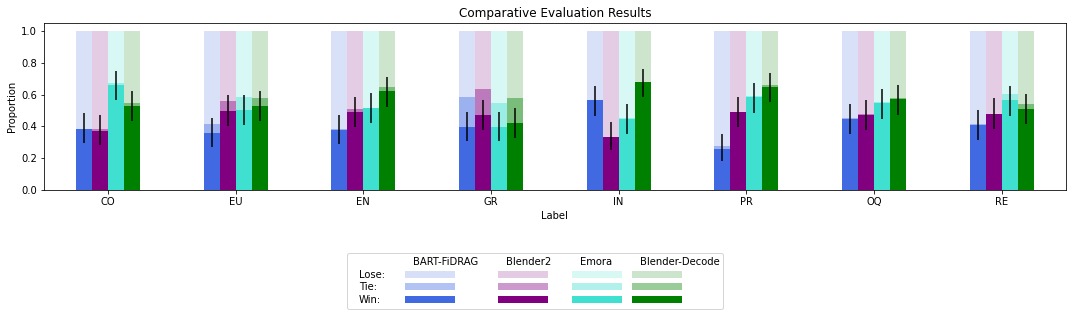

In [337]:
df = plot_comparative(toplot, 'Comparative Evaluation Results', 'win', (15,5))

### Behaviors

In [338]:
def evaluate_behavior_rates(annotations, load=None, reload=None):
    if load:
        return pd.read_csv(load)
    single_annotated = get_singly_annotated(annotations)
    behavior_annotations = single_annotated.xs(category.behavior, level=sym.category)
    label_groups = behavior_annotations.groupby(level=[sym.bot, sym.label])
    means = label_groups.apply(prop_and_ci)
    if reload:
        means.to_csv(reload)
    return means

In [339]:
surge_behavior_rates = evaluate_behavior_rates(
    surge_annotations,
    load='results/surge_behavior_rates'
)
sbr = prettify(surge_behavior_rates,  float_prec=3, col_types={"n": int}, sort_by=["bot", "proportion"], to_csv="results/paper/surge_behavior_rates", index=False)
sbr

,bot,label,proportion,CI low,CI high,n
51,rerank_blender,empathetic,0.433,0.408,0.459,1500
52,rerank_blender,follow up,0.425,0.400,0.450,1500
59,rerank_blender,preference info,0.307,0.285,0.331,1500
62,rerank_blender,topic switch,0.260,0.238,0.283,1500
57,rerank_blender,life info,0.249,0.227,0.271,1500
...,...,...,...,...,...,...
5,bart_fid_rag_bcb,ignore,0.111,0.096,0.128,1512
10,bart_fid_rag_bcb,partner contradiction,0.069,0.058,0.083,1512
12,bart_fid_rag_bcb,redundant,0.051,0.041,0.063,1512
15,bart_fid_rag_bcb,uninterpretable,0.012,0.008,0.019,1512


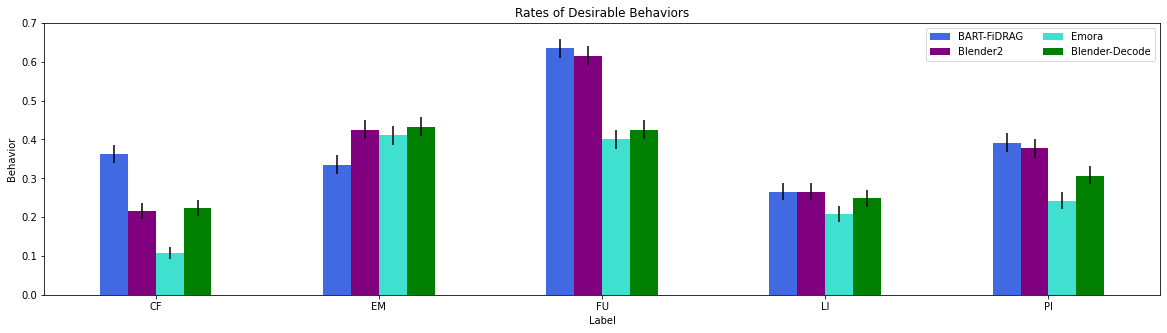

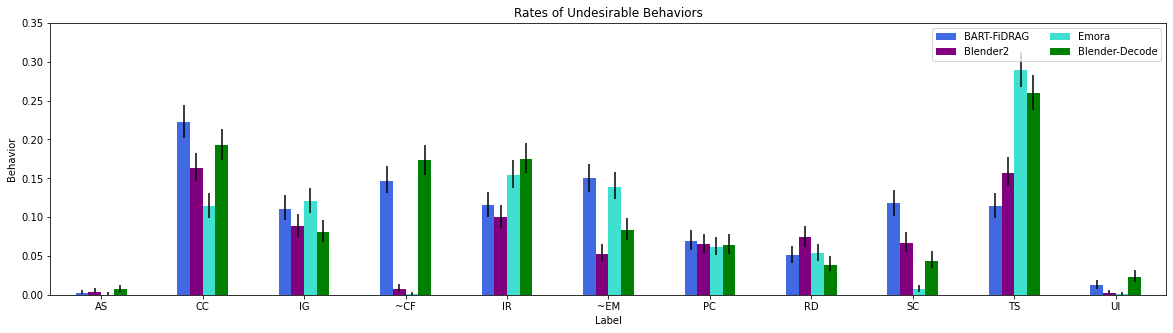

In [340]:
behaviors_transformer = {
    'correct fact': 'CF',
    'empathetic': 'EM',
    'follow up': 'FU',
    'life info': 'LI',
    'preference info': 'PI',
    'uninterpretable': 'UI',
    'antisocial': 'AS',
    'commonsense contradiction': 'CC',
    'ignore': 'IG',
    'incorrect fact': '~CF',
    'irrelevant': 'IR',
    'lack of empathy': '~EM',
    'partner contradiction': 'PC',
    'redundant': 'RD',
    'self contradiction': 'SC',
    'topic switch': 'TS'
}

sbr = sbr.reset_index()
to_maximize = {'correct fact', 'empathetic', 'follow up', 'life info', 'preference info'}
maximize = sbr[sbr['label'].isin(to_maximize)]
grouped_barplot(maximize, title="Rates of Desirable Behaviors", ylabel="Behavior", xlabel='Label', ylim=(0,0.7), value_col="proportion", rot=0, fig_size=(20,5))

to_minimize = {'uninterpretable', 'antisocial', 'commonsense contradiction', 'ignore', 'incorrect fact', 'irrelevant', 'lack of empathy', 'partner contradiction', 'redundant', 'self contradiction', 'topic switch'}
minimize = sbr[sbr['label'].isin(to_minimize)]
grouped_barplot(minimize, title="Rates of Undesirable Behaviors", ylabel="Behavior", xlabel='Label', ylim=(0,0.35), value_col="proportion", rot=0, fig_size=(20,5))

# 8 Evaluation Metric Assessment

### Metric Sensitivity

In [341]:
from itertools import combinations
from scipy.stats import ttest_ind

def t_tests(df: pd.DataFrame):
    """
    :param df: (bot, data point) x 1 -> score
    :return: p values of test on each bot pair (pd.Series)
    """
    bots = set(df.index.get_level_values(0))
    bot_pairs = list(combinations(bots, 2))
    result = {}
    for ba, bb in bot_pairs:
        a = df.xs(ba).to_numpy().squeeze()
        b = df.xs(bb).to_numpy().squeeze()
        t, p = ttest_ind(a, b)
        result[(ba, bb)] = p
    result_series = pd.Series(result.values(), result)
    return result_series

get_singly_annotated(surge_annotations).xs(
    category.likert_turn,
    level=sym.category
).groupby(
    sym.label
).apply(
    t_tests
)

emora                                      blender2_3B  \
              blender2_3B bart_fid_rag_bcb rerank_blender bart_fid_rag_bcb   
label                                                                        
consistent   2.324939e-01     1.086798e-04   1.244491e-02     8.261288e-03   
emotional    3.310844e-11     1.442496e-01   4.694923e-08     1.384936e-06   
engaging     1.257653e-01     7.600987e-09   5.587271e-02     1.333384e-12   
grammatical  9.479605e-05     2.256486e-16   1.120927e-62     4.951771e-29   
informative  2.654901e-09     6.078143e-50   3.316559e-37     2.407452e-23   
proactive    3.148701e-04     1.073099e-75   1.818061e-02     9.246392e-55   
quality      7.182307e-10     9.194573e-05   4.421456e-07     4.958317e-23   
relevant     9.072922e-16     1.045477e-01   3.390145e-02     7.029505e-10   

                           bart_fid_rag_bcb  
            rerank_blender   rerank_blender  
label                                        
consistent    2.111020e-01     1.448190e-01  
emotional     2.770961e-01     1.825506e-04  
engaging      8.349123e-04     1.492934e-04  
grammatical   8.552394e-82     8.309011e-17  
informative   1.877603e-14     3.009638e-02  
proactive     2.740463e-01     1.645665e-56  
quality       7.869890e-30     3.652096e-01  
relevant      1.997931e-24     2.263328e-04

### Predictive Validity

In [342]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

def regressions(df, quality_column_name=None):
    """
    :param df: dialogue x (*features, quality) -> value
    :return: *(coef, low, high), mcfadden r^2
    """
    if not quality_column_name:
        quality_column_name = df.columns[-1]
    qualities = df[quality_column_name]
    features = [f for f in df.columns if f != quality_column_name]
    model = OrderedModel(qualities, df[features], distr='logit')
    results = model.fit()
    coefs = {f: results.params[f] for f in features}
    prsqrd = results.prsquared
    result = {**coefs, stat.mcfad_r2: prsqrd}
    return pd.Series(result.values(), result)

def dialogue_metrics(ev):
    df: pd.DataFrame = ev.annotation_dataframe()
    df = get_singly_annotated(df, seed=123)
    reindexed = df.reset_index()
    items = reindexed[sym.item]
    dialogues = [e[0] if isinstance(e, tuple) else e for e in items]
    reindexed['dialogue'] = dialogues
    reindexed.set_index(
        [sym.bot, sym.category, sym.label, 'dialogue', sym.item],
        inplace=True, verify_integrity=True
    )
    ld = reindexed.xs(category.likert_dialogue, level=sym.category)
    ld = ld.droplevel(sym.bot).droplevel(sym.item)
    ld.columns = ['score']
    ldq = ld.xs(scale.quality, level=sym.label)
    ldq.columns = ['quality']

    lt = reindexed.xs(category.likert_turn, level=sym.category)
    lt = lt.groupby([sym.label, 'dialogue']).mean()
    lt.columns = ['score']
    ltq = lt.xs(scale.quality, level=sym.label)
    ltq.columns = ['quality']

    be = reindexed.xs(category.behavior, level=sym.category)
    be = be.groupby([sym.label, 'dialogue']).mean()
    be.columns = ['score']

    ds = pd.concat(
        [lt, be, ld],
        keys=[category.likert_turn, category.behavior, category.likert_dialogue],
        names=[sym.category, sym.label, 'dialogue']
    )
    likert_dialogue_quality_features = ds.join(ldq, on='dialogue')
    likert_turn_quality_features = ds.join(ltq, on='dialogue')
    return likert_dialogue_quality_features, likert_turn_quality_features

@to_file
def dialogue_quality_regressions(ev):
    ldq, ltq = dialogue_metrics(ev)
    groups = ldq.groupby(
        [sym.category, sym.label]
    )
    result = groups.apply(regressions)
    return result

"""

"""

dialogue_quality_regressions(
    data.surge_evaluation,
    load='results/dialogue_quality_regressions'
)

score  \
category        label                                   
likert turn     consistent                   0.445535   
                emotional                    0.408422   
                engaging                     0.365208   
                grammatical                  0.008647   
                informative                 -0.092100   
                proactive                    0.404827   
                quality                      0.435664   
                relevant                     0.400816   
behavior        antisocial                  -0.238332   
                commonsense contradiction   -4.169573   
                correct fact                -0.196133   
                empathetic                   1.758470   
                follow up                    0.702163   
                ignore                      -3.923478   
                incorrect fact              -1.318389   
                irrelevant                  -3.209895   
                lack of empathy             -3.418165   
                life info                    0.735781   
                partner contradiction       -6.938169   
                preference info              0.417276   
                redundant                   -5.272750   
                self contradiction          -3.396800   
                topic switch                -0.376881   
                uninterpretable             -5.835742   
likert dialogue consistent                   0.894894   
                emotional                    1.004665   
                engaging                     1.476588   
                grammatical                  0.609139   
                informative                  1.011987   
                proactive                    1.105211   
                quality                    118.577127   
                relevant                     1.223033   

                                           McFadden's pseudo-R-squared  
category        label                                                   
likert turn     consistent                                    0.008620  
                emotional                                     0.008024  
                engaging                                      0.008869  
                grammatical                                   0.000003  
                informative                                   0.000462  
                proactive                                     0.010316  
                quality                                       0.008247  
                relevant                                      0.010120  
behavior        antisocial                                    0.000002  
                commonsense contradiction                     0.029706  
                correct fact                                  0.000140  
                empathetic                                    0.014779  
                follow up                                     0.002820  
                ignore                                        0.016215  
                incorrect fact                                0.003545  
                irrelevant                                    0.017496  
                lack of empathy                               0.020080  
                life info                                     0.001481  
                partner contradiction                         0.035305  
                preference info                               0.000747  
                redundant                                     0.015479  
                self contradiction                            0.007829  
                topic switch                                  0.000269  
                uninterpretable                               0.003524  
likert dialogue consistent                                    0.121964  
                emotional                                     0.106875  
                engaging                                      0.1

### Agreement Between Static and Interactive Evaluators